In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow 
from tensorflow import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Input , Rescaling
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input , decode_predictions

2025-11-16 08:48:54.048746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763282934.249978      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763282934.308161      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_data = image_dataset_from_directory(
    '/kaggle/input/car-damage-detection/data1a/training',
    labels = 'inferred',
    label_mode="int",
    image_size = (224 , 224),
    batch_size = 32
)
test_data = image_dataset_from_directory(
    '/kaggle/input/car-damage-detection/data1a/validation',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224 , 224),
    batch_size = 32
)

Found 1840 files belonging to 2 classes.


I0000 00:00:1763282951.709388      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763282951.710100      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 460 files belonging to 2 classes.


In [3]:
for images, labels in train_data.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [4]:
class_name = train_data.class_names

In [5]:
class_name

['00-damage', '01-whole']

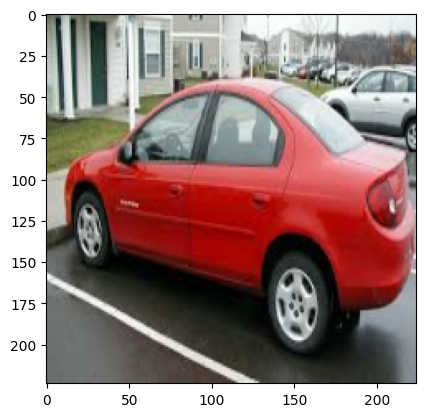

In [6]:
for images, labels in train_data.take(1):
    img = images[0].numpy().astype("uint8")
    plt.imshow(img)

In [7]:
def process(image , label):
    image = preprocess_input(image) 
    return image , label

data_augmentation = tensorflow.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
])

def augment(img, label):
    img = data_augmentation(img, training=True)
    return img, label

train_data = train_data.map(augment, tensorflow.data.AUTOTUNE)
train_data = train_data.map(process)
test_data = test_data.map(process)

In [8]:
train_data = train_data.cache().prefetch(tensorflow.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tensorflow.data.AUTOTUNE)

In [9]:
for images, labels in train_data.take(2):
    img = images[0]

print(img[0][0])

tf.Tensor([ 80.80664   97.969536 112.58431 ], shape=(3,), dtype=float32)


In [10]:
Efficient_Net = EfficientNetB0(include_top = False ,weights="imagenet" , input_shape = (224 , 224 , 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
Efficient_Net.trainable = False

In [12]:
from keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , GlobalAveragePooling2D ,Dropout , BatchNormalization
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal , GlorotUniform
from keras.regularizers import l1_l2 , l1 , l2

model = Sequential()
model.add(Efficient_Net)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(128 , activation = 'relu' , kernel_initializer = HeNormal() , kernel_regularizer = l1_l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64 , activation = 'relu' , kernel_initializer = HeNormal(), kernel_regularizer = l1_l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1 , activation = 'sigmoid'))

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,372 (16.11 MB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [14]:
model.compile(loss = 'binary_crossentropy' ,optimizer = Adam(learning_rate = 1e-4), metrics = ['accuracy'])

In [15]:
callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 10 ,
    mode = 'auto',
    restore_best_weights = True,
    min_delta = 0.001 ,
    verbose = 1
)

In [16]:
history = model.fit(train_data , epochs=80 , validation_data = test_data  , callbacks = callback)

Epoch 1/80


I0000 00:00:1763282970.079271     114 service.cc:148] XLA service 0x7ea624013520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763282970.080069     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763282970.080104     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763282972.358835     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/58 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5573 - loss: 6.8879

I0000 00:00:1763282982.848367     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 581ms/step - accuracy: 0.6329 - loss: 6.7947 - val_accuracy: 0.8543 - val_loss: 6.5828
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8005 - loss: 6.4304 - val_accuracy: 0.8826 - val_loss: 6.3562
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8462 - loss: 6.2394 - val_accuracy: 0.9043 - val_loss: 6.1387
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8660 - loss: 6.0543 - val_accuracy: 0.9043 - val_loss: 5.9363
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8971 - loss: 5.8490 - val_accuracy: 0.9109 - val_loss: 5.7484
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8968 - loss: 5.7000 - val_accuracy: 0.9174 - val_loss: 5.5715
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9171 - loss: 5.5169 - val_accuracy: 0.9174 - val_loss: 5.4020
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9251 - loss: 5.3570 - val_accuracy: 0.9217 - val_loss: 

In [17]:
loss, accuracy = model.evaluate(test_data)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9336 - loss: 0.6920
Validation Accuracy: 93.48%


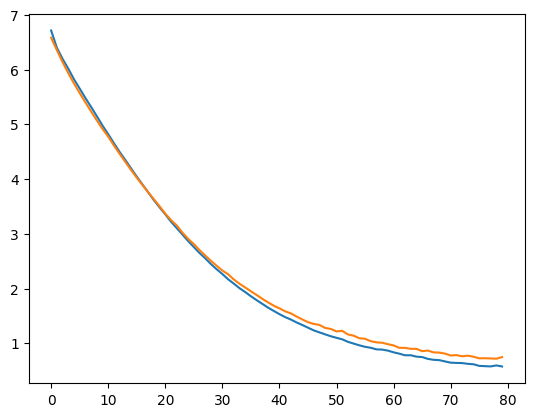

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_damage(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)        
    img_array = preprocess_input(img_array)                
    
    pred = model.predict(img_array, verbose=0)
    prob = pred[0][0]                                     
    
    if prob < 0.5:                                         
        return "DAMAGED", 1 - prob
    else:
        return "NOT DAMAGED", prob

damage_folder = '/kaggle/input/car-damage-detection/data1a/validation/00-damage'
whole_folder  = '/kaggle/input/car-damage-detection/data1a/validation/01-whole'

damage_images = sorted([f for f in os.listdir(damage_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))])[:200]
whole_images  = sorted([f for f in os.listdir(whole_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))])[:200]

correct_damage = 0
correct_whole  = 0

print("Testing first 50 DAMAGED images (should predict 'DAMAGED')...")
for img_name in damage_images:
    path = os.path.join(damage_folder, img_name)
    label, confidence = predict_damage(path)
    if label == "DAMAGED":
        correct_damage += 1
        
print(f"\nDamaged → Correct: {correct_damage}/50\n")

print("Testing first 50 WHOLE images (should predict 'NOT DAMAGED')...")
for img_name in whole_images:
    path = os.path.join(whole_folder, img_name)
    label, confidence = predict_damage(path)
    if label == "NOT DAMAGED":
        correct_whole += 1

print(f"Whole → Correct: {correct_whole}/200\n")

total_correct = correct_damage + correct_whole
total_tested  = 400

print("="*60)
print(f"          FINAL RESULT (validation images)")
print("="*60)
print(f"Damaged images correct     : {correct_damage}/200")
print(f"Whole images correct       : {correct_whole}/200")
print(f"Overall Accuracy           : {total_correct}/{total_tested} → {total_correct/total_tested:.1%}")
print("="*60)

Testing first 50 DAMAGED images (should predict 'DAMAGED')...

Damaged → Correct: 187/50

Testing first 50 WHOLE images (should predict 'NOT DAMAGED')...
Whole → Correct: 196/200

          FINAL RESULT (validation images)
Damaged images correct     : 187/200
Whole images correct       : 196/200
Overall Accuracy           : 383/400 → 95.8%


In [23]:
model.save('car_damage_detection.keras')

import json
class_labels = {
    "0": "DAMAGED",     
    "1": "NOT DAMAGED"   
}
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)